In [1]:
import numpy as np
import scipy
import implicit
import os
import pandas as pd

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.21.4
1.7.3
0.4.8


# 1) 데이터 준비와 전처리

In [2]:
rating_file_path = './data/ml-1m/ratings.dat'
ratings_cols = ['user_id','movie_id','ratings','timestamp']
ratings = pd.read_csv(rating_file_path,sep='::',names=ratings_cols)
original_data_size = len(ratings)
ratings.head()

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)
print(f'orginal_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
ratings.rename(columns={'ratings':'counts'},inplace=True)
ratings.head(3)

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [5]:
movie_file_path = './data/ml-1m/movies.dat'
cols = ['movie_id','title','genre']
movies = pd.read_csv(movie_file_path,sep='::',names=cols,engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# 2) 분석해 봅시다.

### 2-1) ratings에 있는 유니크한 영화 개수

In [6]:
ratings['movie_id'].nunique()

3628

### 2-2) ratings에 있는 유니크한 사용자 수

In [7]:
ratings['user_id'].nunique()

6039

### 2-3) 가장 인기 있는 영화 30개(인기순)

In [8]:
popular = ratings.groupby('movie_id')['user_id'].count()
popular.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [9]:
#my_favorite_title = ['Die Hard (1988)','Volcano (1997)','Men in Black (1997)','Truman Show, The (1998)','Good Will Hunting (1997)']
my_favorite_id = [1036,1515,1580,1682,1704]
my_movielist = pd.DataFrame({'user_id':[6041]*5 ,'movie_id':my_favorite_id,'counts':[3,3,4,5,5],'timestamp':[2301250760]*5})

if not ratings.isin({'user_id':[6041]})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    ratings = ratings.append(my_movielist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

ratings.tail(10) 

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,6041,1036,3,2301250760
1,6041,1515,3,2301250760
2,6041,1580,4,2301250760
3,6041,1682,5,2301250760
4,6041,1704,5,2301250760


# 4) CSR matrix를 직접 만들어 봅시다.

In [10]:
print(ratings.user_id.max())
print(ratings['user_id'].nunique())

print(ratings.movie_id.max())
print(ratings['movie_id'].nunique())

6041
6040
3952
3628


In [11]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()+2
num_movie = ratings['movie_id'].nunique()+325

csr_data = csr_matrix((ratings.counts,(ratings.user_id,ratings.movie_id)),shape=(num_user,num_movie))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [12]:
from implicit.als import AlternatingLeastSquares
import numpy as np

os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

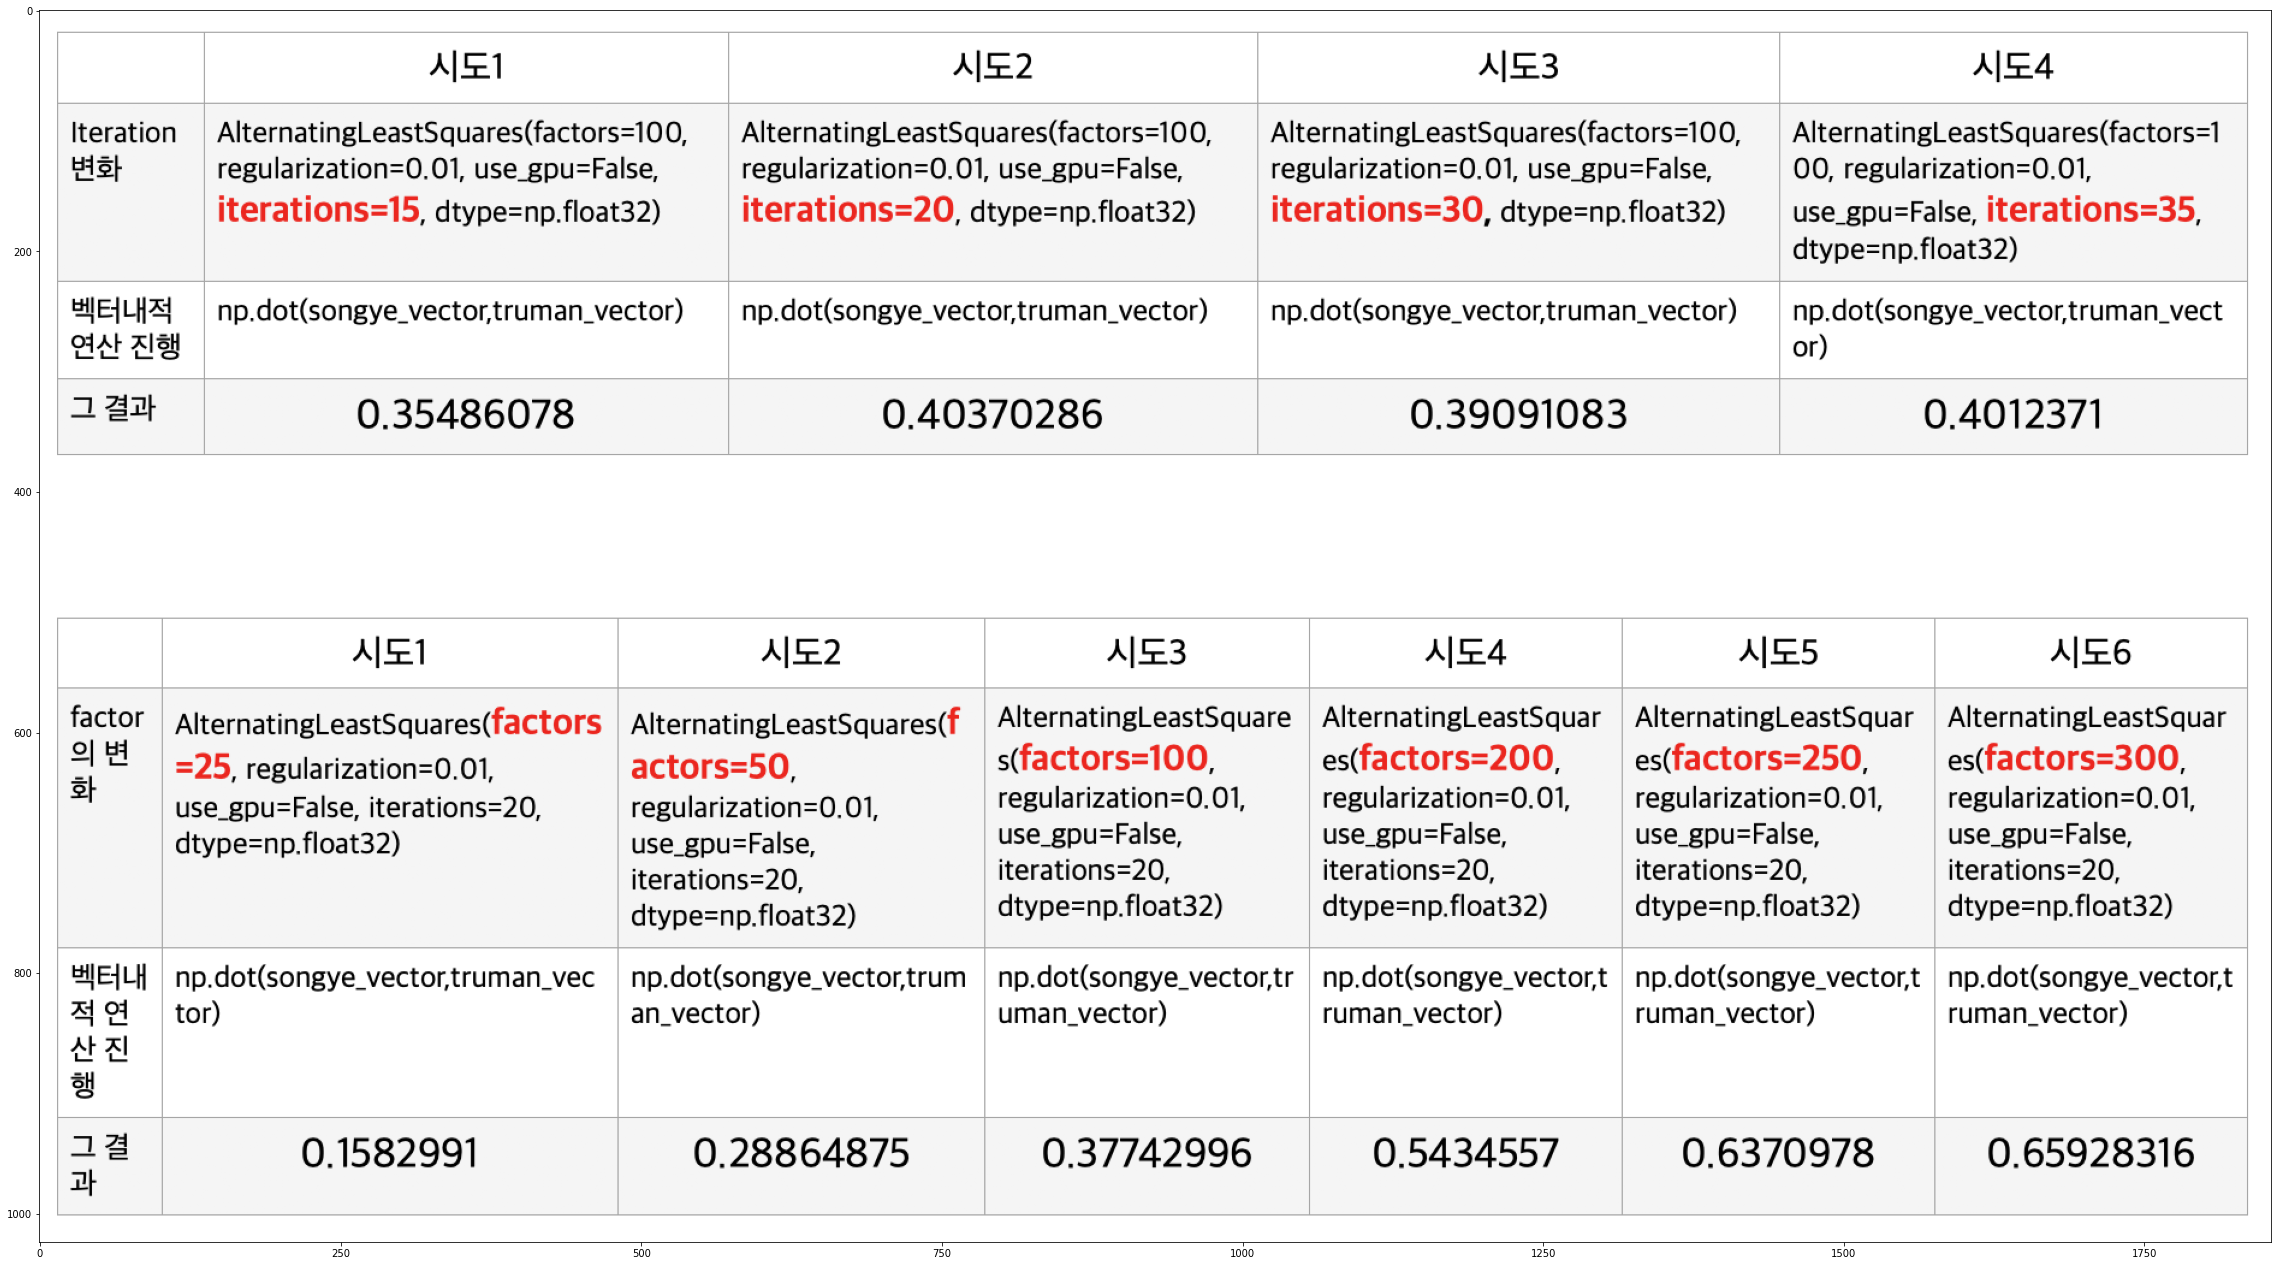

In [14]:
import matplotlib.image as img
import matplotlib.pyplot as plt
plt.figure(figsize = (40,40))
img_test = img.imread('result.png')
plt.imshow(img_test)
plt.show()

In [15]:
#위의 결과에 따라 factors=250, iteration=20 사용
als_model = AlternatingLeastSquares(factors=250, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [16]:
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [17]:
als_model.fit(csr_data_transpose)

100%|███████████████████████████████████████████| 20/20 [00:28<00:00,  1.44s/it]


# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [18]:
songye,truman = 6041, 1682
songye_vector, truman_vector = als_model.user_factors[songye],als_model.item_factors[truman]

In [19]:
songye_vector

array([ 0.38904423, -0.12511237, -0.3482261 ,  0.13971567,  0.2860222 ,
       -0.0465572 , -0.2294062 ,  0.14458261,  0.40830675, -0.23002166,
        0.33724526,  0.30992317, -0.40789217,  0.9519207 ,  0.17642254,
       -0.44360715, -0.10430223, -0.12055235,  0.19769707, -0.22963214,
       -0.2384621 , -0.10829051, -0.25640288,  0.20779534, -0.3460451 ,
       -0.13496003, -0.2311602 , -0.51191455,  0.19421904,  0.23401003,
        0.14749019, -0.05181659,  0.07666639, -0.31747717,  0.35415962,
       -0.25468594, -0.10392758, -0.17053474,  0.11843681, -0.01764459,
       -0.44948792,  0.05055663, -0.13181485,  0.06240668, -0.10781199,
       -0.24360007, -0.03453219,  0.2112514 , -0.1731226 , -0.3020302 ,
       -0.34755364, -0.35517585,  0.40548834, -0.46501932, -0.59607667,
        0.30799124,  0.4046944 , -0.20889822, -0.34332657,  0.33652422,
        0.84350204, -0.22234148, -0.63752866, -0.25755212,  0.07173873,
        0.6366211 ,  0.31357706,  0.24423836, -0.05043171, -0.74

In [20]:
np.dot(songye_vector,truman_vector)

0.6450964

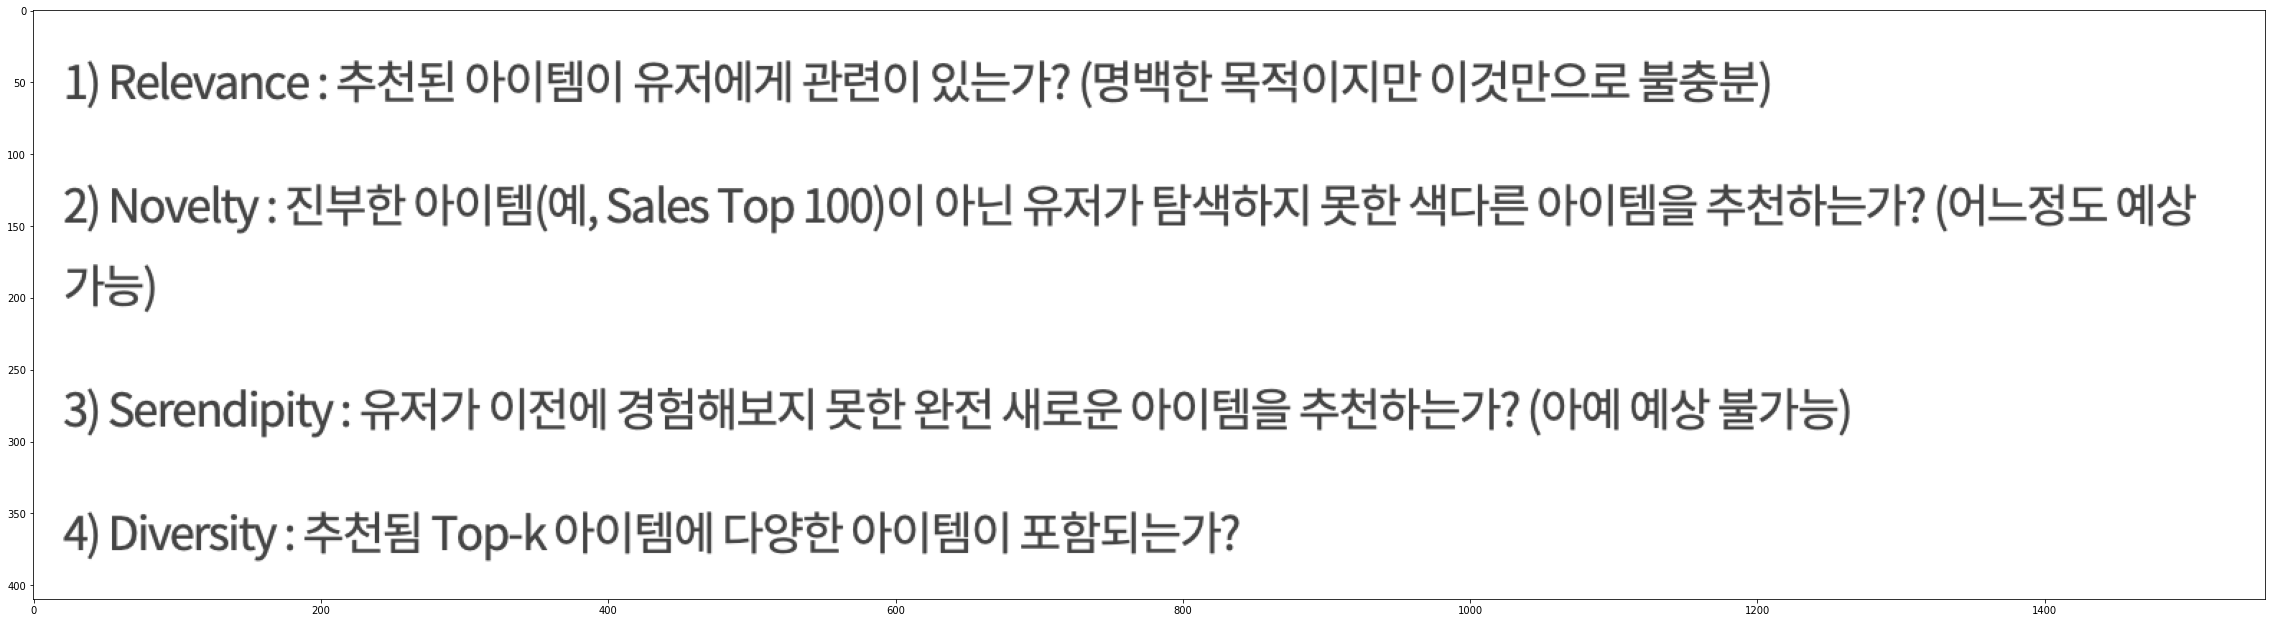

In [21]:
import matplotlib.image as img
import matplotlib.pyplot as plt

plt.figure(figsize = (40,40))
img_test = img.imread('metrics.png')
plt.imshow(img_test)
plt.show()

### 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [22]:
#롱테일의 법칙 80:20의 법칙
similar_movie = als_model.similar_items(3,N=15)

In [23]:
#함수로 만들기 
def get_similar_movie(movie_name:str):
    movie_id = movies[movies['title']==movie_name].movie_id.tolist()[0]
    similar_movie = als_model.similar_items(movie_id,N=15)
    for i in similar_movie:
        print(movies[movies['movie_id']==i[0]].title.tolist()[0],i[1])

In [24]:
get_similar_movie('Grumpier Old Men (1995)')

Grumpier Old Men (1995) 1.0000001
Grumpy Old Men (1993) 0.6608622
Milk Money (1994) 0.5258046
Out to Sea (1997) 0.5163844
Odd Couple II, The (1998) 0.50730175
Two if by Sea (1996) 0.50255954
Nine Months (1995) 0.49618575
Vegas Vacation (1997) 0.4953292
Fathers' Day (1997) 0.4952997
Richie Rich (1994) 0.4875036
Sorority House Massacre II (1990) 0.4837911
Simpatico (1999) 0.48276362
Favor, The (1994) 0.4822653
Gone Fishin' (1997) 0.48059273
Major League: Back to the Minors (1998) 0.4790881


# 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [25]:
def recommend_movie(user_idx:int):
    artist_recommended = als_model.recommend(user_idx,csr_data,N=20,filter_already_liked_items=True)
    for i in artist_recommended:
        print(movies[movies['movie_id']==i[0]].title.tolist()[0],i[1])

In [26]:
recommend_movie(6041)

Apollo 13 (1995) 0.28850406
Jerry Maguire (1996) 0.23385791
Fifth Element, The (1997) 0.22695945
Face/Off (1997) 0.20143865
Raiders of the Lost Ark (1981) 0.18956403
Princess Bride, The (1987) 0.18722713
Wag the Dog (1997) 0.18692853
Galaxy Quest (1999) 0.18053958
Jurassic Park (1993) 0.17246032
Total Recall (1990) 0.17164071
Fugitive, The (1993) 0.16855586
Forrest Gump (1994) 0.16490047
Indiana Jones and the Last Crusade (1989) 0.16345485
Terminator, The (1984) 0.16110165
Mr. Holland's Opus (1995) 0.15653642
Sixth Sense, The (1999) 0.15560022
Insider, The (1999) 0.15349467
Contact (1997) 0.15048403
Few Good Men, A (1992) 0.15033922
Fight Club (1999) 0.14518449


# 모델 평가하기 1

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


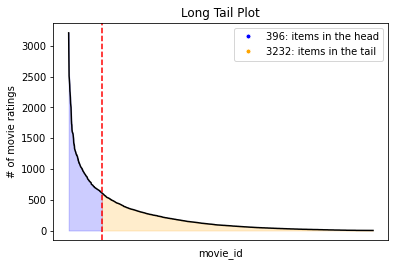

In [33]:
import recmetrics
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movie_id", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# 번외 ) 모델 평가하기 

### 1) Long tail plot 그려보기 

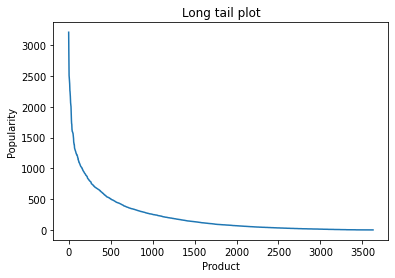

In [165]:
#long tail의 법칙 확인하기
#기본적으로 사람들이 많이 소비하는 것들만 소비된다. 
import matplotlib.pyplot as plt

movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count = movie_count.sort_values(ascending=False).tolist()
plt.title("Long tail plot")
plt.ylabel("Popularity")
plt.xlabel("Product")
plt.plot(movie_count)

# recometrics를 이용해 모델 평가해보기 

In [ ]:
import recometrics as rc
# https://github.com/david-cortes/recometrics
#https://nbviewer.org/github/david-cortes/recometrics/blob/master/examples/recometrics_example.ipynb

### 희소 행렬 만들기 

In [215]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()+2
num_movie = ratings['movie_id'].nunique()+325

csr_data = csr_matrix((ratings.counts,(ratings.user_id,ratings.movie_id)),shape=(num_user,num_movie))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

### Creating a train-test split

In [216]:
X_train,X_test,users_test = rc.split_reco_train_test(csr_data,
                                                    split_type='joined',
                                                    users_test_fraction=None,
                                                    max_test_users=10000,
                                                    items_test_fraction=0.3)
X_test

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/recometrics/__init__.py:813: UserWarning: 'max_test_users' is larger than number of users. Will take all.
  warn("'max_test_users' is larger than number of users. Will take all.")


<6039x3953 sparse matrix of type '<class 'numpy.float64'>'
	with 251238 stored elements in Compressed Sparse Row format>

### Establishing baselines

In [223]:
from  cmfrec import MostPopular
#https://cmfrec.readthedocs.io/en/latest/ 참고하기 

#random recommendations
rng = np.random.default_rng(seed=1)
userFactors_random = rng.standard_normal(size=(X_test.shape[0],5))
itemFactors_random = rng.standard_normal(size=(X_test.shape[1],5))

#non_personalized recommendations
model_baseline = MostPopular(implicit=True,user_bias=False).fit(X_train.tocoo())
item_biases = model_baseline.item_bias_
item_biases

array([0.        , 0.61041458, 0.24054706, ..., 0.02636687, 0.02255029,
       0.17366548])

### Fitting models

In [220]:
from implicit.als import AlternatingLeastSquares
from lightfm import LightFM

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


#### 모델1) implicit-ALS ("iALS") model.

In [221]:
wrmf = AlternatingLeastSquares(factors=50, regularization=1, random_state=123)
wrmf.fit(X_train.T)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.72it/s]


#### 모델 2)"Bayesian Personalized Ranking" model

In [222]:
bpr_warp = LightFM(no_components=50, loss="warp", random_state=123)
bpr_warp.fit(X_train.tocoo())

### Calculating metrics

In [226]:
k = 5 ## Top-K recommendations to evaluate

metrics_random = rc.calc_reco_metrics(
    X_train[:X_test.shape[0]], X_test,
    userFactors_random, itemFactors_random,
    k=k, all_metrics=True
)

metrics_baseline = rc.calc_reco_metrics(
    X_train[:X_test.shape[0]], X_test,
    None, None, item_biases=item_biases,
    k=k, all_metrics=True
)

metrics_wrmf = rc.calc_reco_metrics(
    X_train[:X_test.shape[0]], X_test,
    wrmf.user_factors[:X_test.shape[0]], wrmf.item_factors,
    k=k, all_metrics=True
)

metrics_bpr_warp = rc.calc_reco_metrics(
    X_train[:X_test.shape[0]], X_test,
    bpr_warp.user_embeddings[:X_test.shape[0]], bpr_warp.item_embeddings,
    item_biases=bpr_warp.item_biases,
    k=k, all_metrics=True
)

/Users/songye/opt/anaconda3/envs/aiffel/lib/python3.7/site-packages/recometrics/__init__.py:520: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warn(msg_omp)


In [227]:
metrics_baseline

,P@5,TP@5,R@5,AP@5,TAP@5,NDCG@5,Hit@5,RR@5,ROC_AUC,PR_AUC
0,0.2,0.2,0.062500,0.020833,0.066667,0.143629,1.0,0.333333,0.906298,0.081141
1,0.4,0.4,0.057143,0.033333,0.233333,0.306853,1.0,0.500000,0.911240,0.105419
2,0.2,0.2,0.071429,0.071429,0.200000,0.271328,1.0,1.000000,0.937475,0.140032
3,0.4,0.4,0.333333,0.122222,0.146667,0.239231,1.0,0.333333,0.967421,0.149030
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.830495,0.071003
...,...,...,...,...,...,...,...,...,...,...
6034,0.2,0.2,0.017544,0.004386,0.050000,0.087641,1.0,0.250000,0.901565,0.176404
6035,0.2,0.2,0.200000,0.050000,0.050000,0.143843,1.0,0.250000,0.925693,0.068565
6036,0.2,0.2,0.027778,0.009259,0.066667,0.169580,1.0,0.333333,0.867451,0.059237
6037,0.8,0.8,0.048193,0.042771,0.710000,0.595298,1.0,1.000000,0.857833,0.200768


### Comparing models

In [228]:
all_metrics = [
    metrics_random,
    metrics_baseline,
    metrics_wrmf,
    metrics_bpr_warp
]
all_metrics = pd.concat([m.mean(axis=0).to_frame().T for m in all_metrics], axis=0)
all_metrics.index = [
    "Random",
    "Non-personalized",
    "WRMF (a.k.a. iALS)",
    "BPR-WARP"
]
all_metrics

,P@5,TP@5,R@5,AP@5,TAP@5,NDCG@5,Hit@5,RR@5,ROC_AUC,PR_AUC
Random,0.008478,0.008478,0.000942,0.000395,0.003968,0.006717,0.040570,0.018772,0.500525,0.012870
Non-personalized,0.250571,0.250626,0.039367,0.025749,0.183558,0.234188,0.612850,0.413416,0.877888,0.122040
WRMF (a.k.a. iALS),0.457590,0.457794,0.093665,0.069310,0.366693,0.427827,0.882596,0.681710,0.920488,0.271682
BPR-WARP,0.339060,0.339185,0.054644,0.038141,0.265743,0.317168,0.722967,0.527883,0.905209,0.168557


In [ ]:
#위의 결과를 보게 되면 대부분의 경우 Random한 데이터 결과보다는 모델을 이용해서 추천한 것들의 metrics결과가 좋다. 
#WRMF 모델과 BPR-WARP모델의 경우 측정 지표에 따라 어떤 모델이 더 우수한지 달라진다. 

# https://github.com/statisticianinstilettos/recmetrics

# train 데이터를 적절히 활용하는 법

### 방법1) 학습데이터에서 매우 인기있는 데이터를 제거해보자.

In [ ]:
#이렇게 하면 원래 인기가 많았던 데이터가 아니라 노출이 적었던 작품에 대해서도 추천해줄 수 있지 않을까?

### 방법2) 사용자의 등급에 따라 평점을 scaling 해보자. 

In [ ]:
# 이렇게 하면 영화를 더 많이 본 사용자들이 좋게 평가한 작품을 더 추천해줄 수 있지 않을까?